# Notes for stress data
- StudentGrades.txt contains the grades for each student 
- The Data.zip file contains folders for each participants named as S1, S2, etc.
- Under each of the folders corresponding to each partcipants, there are three folders 'Final', 'Midterm 1', and 'Midterm 2', corresponding to three exams.
- Each of the folders contains csv files: 'ACC.csv', 'BVP.csv', 'EDA.csv', 'HR.csv', 'IBI.csv', 'tags.csv', 'TEMP.csv', and 'info.txt'.
- 'info.txt' contains detailed information of each of these files.
- All the unix time stamps are date shifted for deidentification but not time shifted. The date shift have been carried out such a way that it does not change the status of the day light saving settings (CT/CDT) of a day.
- All exam starts at 9:00 AM (CT or CDT depending on the date corresponding to the unix time stamp). Mid terms are 1.5 hr long and final is 3 hr long.
- Sampling frequency of the arrays are given with the structs
- The dataset contains two female and eight male participants, however the gender is not mentioned for the purpose of deidentification

The first row is the initial time of the session expressed as unix timestamp in UTC.
The second row is the sample rate expressed in Hz.

TEMP.csv
Data from temperature sensor expressed degrees on the Celsius (°C) scale.

EDA.csv
Data from the electrodermal activity sensor expressed as microsiemens (μS).

BVP.csv
Data from photoplethysmograph.

ACC.csv
Data from 3-axis accelerometer sensor. The accelerometer is configured to measure acceleration in the range [-2g, 2g]. Therefore the unit in this file is 1/64g.
Data from x, y, and z axis are respectively in first, second, and third column.

IBI.csv
Time between individuals heart beats extracted from the BVP signal.
No sample rate is needed for this file.
The first column is the time (respect to the initial time) of the detected inter-beat interval expressed in seconds (s).
The second column is the duration in seconds (s) of the detected inter-beat interval (i.e., the distance in seconds from the previous beat).

HR.csv
Average heart rate extracted from the BVP signal.The first row is the initial time of the session expressed as unix timestamp in UTC.
The second row is the sample rate expressed in Hz.


tags.csv
Event mark times.
Each row corresponds to a physical button press on the device; the same time as the status LED is first illuminated.
The time is expressed as a unix timestamp in UTC and it is synchronized with initial time of the session indicated in the related data files from the corresponding session.

In [211]:
import os
from zipfile import ZipFile
from typing import Dict, List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
from datetime import datetime

In [191]:
main_file_name = 'a-wearable-exam-stress-dataset-for-predicting-cognitive-performance-in-real-world-settings-1.0.0.zip'
sub_file_name = 'Data.zip'

# New directory
path = main_file_name[:-4]

full_path = os.path.join(path, sub_file_name)

In [192]:
def zip_extraction(file_name: str, extract_dir: str = None) -> None:
    """
    Extract the zip file in `file_name` into the directory `extract_dir`.
    
    param file_name: Zip file that is going to be extracted. 
    param extract_dir: Directory in which `file_name` will be extracted. By default, it's value is None, what means it is
        going to be extracted on the current path. 
    """
    with ZipFile(file_name, 'r') as zip:
        zip.printdir()
        print('Extrayendo archivos')
        zip.extractall(path=extract_dir)
        print('Finalizado')

In [193]:
zip_extraction(main_file_name) # Extracting main zip
zip_extraction(full_path, path) # Extracting zip with students data contained. 

File Name                                             Modified             Size
a-wearable-exam-stress-dataset-for-predicting-cognitive-performance-in-real-world-settings-1.0.0/Data.zip 2022-04-03 21:13:28     86016326
a-wearable-exam-stress-dataset-for-predicting-cognitive-performance-in-real-world-settings-1.0.0/LICENSE.txt 2022-05-24 08:04:06        20402
a-wearable-exam-stress-dataset-for-predicting-cognitive-performance-in-real-world-settings-1.0.0/SHA256SUMS.txt 2022-05-26 12:50:46          309
a-wearable-exam-stress-dataset-for-predicting-cognitive-performance-in-real-world-settings-1.0.0/StudentGrades.txt 2021-12-14 12:49:18          470
a-wearable-exam-stress-dataset-for-predicting-cognitive-performance-in-real-world-settings-1.0.0/readme.md 2022-04-03 21:56:08         1104
Extrayendo archivos
Finalizado
File Name                                             Modified             Size
Data/S1/                                       2022-04-03 19:58:54            0
Data/S1/Final/ 

## Reading files

In [194]:
# Define column names for each variable
physio_variables = {'ACC': ['x', 'y', 'z'], 
                    'BVP': ['BVP'], 
                    'EDA': ['EDA'], 
                    'HR': ['HR'], 
                    'IBI':['Time', 'Interval duration'], 
                    'TEMP':['TEMP']
                   }

# Define types of exam
exam_list = ['Final', 'Midterm 1', 'Midterm 2']

# Define students list
students_list = [f'S{i}' for i in range(1, 11)]

In [200]:
students_dict = {}
time_freq_dict = {} # It is necessary to verify CT vs. CDT

for student in students_list: # Loop over each student
    students_dict[student], time_freq_dict[student] = {}, {}
    for exam in exam_list: # Loop over each type of exam in `exam_list`
        students_dict[student][exam], time_freq_dict[student][exam] = {}, {}
        for physio_var, values in physio_variables.items(): # Loop over each physiological variable
            read_data = pd.read_csv(f'a-wearable-exam-stress-dataset-for-predicting-cognitive-performance-'\
                                    f'in-real-world-settings-1.0.0/Data/{student}/{exam}/{physio_var}.csv', 
                                    names=values,
                                    )
            time_freq_dict[student][exam][physio_var] = read_data.loc[0:1, :]
            time_freq_dict[student][exam][physio_var].index = ['Initial time (Unix)', 'Sample rate']
            students_dict[student][exam][physio_var] = read_data.loc[2:, :] 

In [196]:
# Reading grades
grades_path = os.path.join(path, 'StudentGrades.txt')
total_grades = pd.read_csv(grades_path, encoding='ISO-8859-1', names=['TOTAL GRADES'])

print('Original students grades data')
display(total_grades.head(15))

# Identify '-----' rows
hyphen_rows = total_grades['TOTAL GRADES'].apply(lambda x: '--' in x)
# Find rows with a column name value
column_rows = total_grades['TOTAL GRADES'].apply(lambda x: 'GRADES' in x)
# Filter rows without hyphen and rename rows with column names
total_grades = total_grades[~hyphen_rows]
exam_label = total_grades['TOTAL GRADES'][column_rows].apply(lambda x: x[9:])

# Generate new DataFrame with each exam as a column
exam_data = pd.DataFrame({exam_type: total_grades.loc[index + 2:index + 11, 
                                                      'TOTAL GRADES'].apply(lambda x: int(x[-2:])).values
             for index, exam_type in exam_label.items()}, 
             index=students_list)

print('Adjusted students grades data')
display(exam_data)
    



Original students grades data


,TOTAL GRADES
0,GRADES - MIDTERM 1
1,------------------
2,S01  78
3,S02  82
4,S03  77
5,S04  75
6,S05  67
7,S06  71
8,S07  64
9,S08  92


Adjusted students grades data


,MIDTERM 1,MIDTERM 2,FINAL (OUT OF 200)
S1,78,82,82
S2,82,85,80
S3,77,90,88
S4,75,77,49
S5,67,77,57
S6,71,64,75
S7,64,33,10
S8,92,88,84
S9,80,39,26
S10,89,64,16


## Defining DataFrames per sensor

In [197]:
def extract_physio_dict(physio_var: str, students_list: List[str], exam_list: List[str], 
                              students_info: Dict[str, Dict]) -> Dict[str, np.array]:
    """
    Generate a new DataFrame with all the registered data of the same physiological value. Each column is the signal values
    for each student and the specific exam. 
    
    param physio_var: Variable from which the total DataFrame will be generated.
    param students_list: List of students that will be included in columns of DataFrame.
    param exam_list: List of types of exam that will be included in columns of DataFrame.
    param student_info: Dictionary from which physiological information will be extracted. 
    return: Dictionary with the values of the same variable. The new columns will be generated with the name 
        "`physio_var`+`exam`" where `exam` is the specific type of exam.
    """
    new_data = {f'{student} + {exam}': students_info[student][exam][physio_var].values.flatten() 
                for student in students_list for exam in exam_list}
    return new_data

In [198]:
heart_rate = extract_physio_dict('HR', students_list, exam_list, students_dict)
eda_data = extract_physio_dict('EDA', students_list, exam_list, students_dict)
temperature = extract_physio_dict('TEMP', students_list, exam_list, students_dict)
bvp_data = extract_physio_dict('BVP', students_list, exam_list, students_dict)

## Data visualization

In [208]:
srate = time_freq_dict['S10']['Midterm 2']['HR'].loc['Sample rate', :].values
print(srate)

signal = heart_rate['S10 + Midterm 2']
n = len(signal)
t = np.arange(0, n) / srate

print(t)

[1.]
[0.0000e+00 1.0000e+00 2.0000e+00 ... 1.2979e+04 1.2980e+04 1.2981e+04]


c:\Users\jfore\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\jfore\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\jfore\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\jfore\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\jfore\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\jfore\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: RankWarning: 

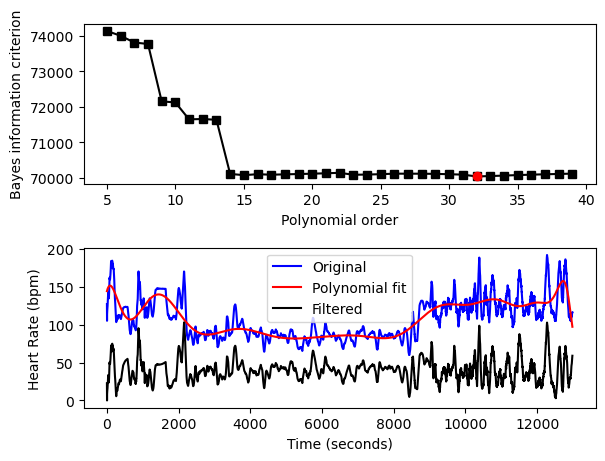

In [210]:


# Generate plot for signal

fig, ax = plt.subplots(2, 1)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)


# Possible orders for filtering
orders = range(5,40)

# Sum of squared errors
sum_sq_err = np.zeros(len(orders))

# loop through orders
for ri in range(len(orders)):
    
    # compute polynomial (fitting time series)
    y_hat = np.polyval(np.polyfit(t, signal, orders[ri]),t)
    
    # compute fit of model to data (sum of squared errors)
    sum_sq_err[ri] = np.sum((y_hat-signal)**2)/n


# Bayes information criterion
bic = n*np.log(sum_sq_err) + orders*np.log(n)

# best parameter has lowest BIC
bestP = min(bic)
idx = np.argmin(bic)

# plot the BIC
ax[0].plot(orders,bic,'ks-', orders[idx],bestP,'ro')
ax[0].set_xlabel('Polynomial order')
ax[0].set_ylabel('Bayes information criterion')

## now repeat filter for best (smallest) BIC

# polynomial fit
polycoefs = np.polyfit(t,signal,orders[idx])

# estimated data based on the coefficients
y_hat = np.polyval(polycoefs,t)

# filtered signal is residual
filtsig = signal - y_hat
filtsig = filtsig + np.abs(min(filtsig))

## plotting
ax[1].plot(t, signal, 'b', label='Original')
ax[1].plot(t, y_hat, 'r', label='Polynomial fit')
ax[1].plot(t, filtsig, 'k', label='Filtered')

ax[1].set_xlabel('Time (seconds)')
ax[1].set_ylabel('Heart Rate (bpm)')
ax[1].legend(loc='best')
plt.show()

In [212]:
# vector of frequencies in Hz
hz = np.linspace(0, srate/2, int(np.floor(n/2)+1))

# amplitude spectrum via Fourier transform
signalX = scipy.fftpack.fft(signal)
signalAmp = 2*np.abs(signalX)/n

# vector of frequencies in Hz
hz = np.linspace(0,srate/2,int(np.floor(n/2)+1))

C:\Users\jfore\AppData\Local\Temp\ipykernel_27508\254143238.py:1: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(hz,signalAmp[0:len(hz)],'k')


NameError: name 'frex' is not defined

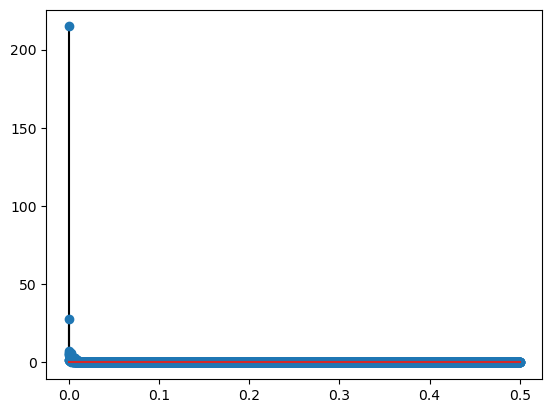

In [218]:
plt.stem(hz,signalAmp[0:len(hz)],'k')
plt.xlim([0,np.max(frex)*3])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency domain')
plt.show()